<!-- O plano e fazer a extracao exclusiva da elite. Quero reaproveitar o que peguei de todos e juntar com o que ja tenho da elite.

Depois, vou pegar o grupo de pessoas da elite que nao foram contempladas e dividir nos grupos de “precisa contemplar” e “incontemplaveis” (aqueles que ja deram erro porque nao existem ou porque ha zero tweets nas datas propostas). 

✅✅✅

-->

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Bios

#### Dados

In [2]:
# bios, pontos ideais e classificacoes de fatia
import json

# bios
with open('bios-elite.json', 'r') as arquivo:
    bios = json.load(arquivo)

elite = pd.DataFrame(list(bios.items()), columns=['user_id', 'user_bio'])
elite['user_id'] = elite['user_id'].astype(int)

# pontos ideais + outras infos
elite_infos = pd.read_csv('elite_info_final.csv').drop(columns=['Unnamed: 0'])
elite_infos['user_id'] = elite_infos['user_id'].astype(int)

elite_infos = elite.merge(
    elite_infos,
    on='user_id',
    how='right')

# vamos usar as mesmas keywords dos influencers (mas tambem vamos analisar a bio original)
influencers_referencia = pd.read_csv('influencers_referencia.csv')
profissoes = list(set([word for sublist in [words.split(', ') for words in influencers_referencia['profissoes'].dropna().to_list()] for word in sublist]))
keywords = list(set([word for sublist in [words.split(', ') for words in influencers_referencia['key words'].dropna().to_list()] for word in sublist]))

# retirando acentos e caracteres especiais
import re
import unidecode
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Inicializa os recursos de NLP
stop_words_add = ['sobre', 'gente', 'aqui', 'hoje', 'voce', 'vc', 'ne', 
                  'pessoas', 'pra', 'ai', 'bom', 'fazer', 'dia', 
                  'ano', 'vai', 'nada', 'ter', 'vou', 'ate', 'ta', 
                  'ja', 'pq', 'assim', 'nao', 'tudo', 'sao', 'acho', 'tbm', 'sei']
stop_words = set(stopwords.words('portuguese') + stop_words_add)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    if not isinstance(tweet, str):
        return ''
    tweet = re.sub(r'\bk+\b', '', tweet)
    tweet = re.sub(r'\bhaha+\b', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    tweet = re.sub(r'http\S+|@\S+|RT', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = tweet.lower()
    tweet = unidecode.unidecode(tweet)
    tokens = [word for word in tweet.split() if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

profissoes = [preprocess_tweet(p) for p in profissoes]
keywords = [preprocess_tweet(k) for k in keywords]

def extrair_substrings(texto, palavras):
    return ' '.join(list(set([palavra.strip() for palavra in palavras if palavra in texto])))

elite_infos['user_bio_clean'] = elite_infos.user_bio.apply(preprocess_tweet)
elite_infos['user_profissoes'] = elite_infos['user_bio_clean'].apply(lambda x: extrair_substrings(x, profissoes))
elite_infos['user_keywords'] = elite_infos['user_bio_clean'].apply(lambda x: extrair_substrings(x, keywords))

elite_infos.head()

[nltk_data] Downloading package wordnet to /home/mindera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mindera/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mindera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


user_id                                           user_bio  \
0  276929286  Advogado, Professor de Dto de Família e Sucess...   
1  353508332      Locutor De Rodeio \nApresentador \nPecuarista   
2  464967698                                                NaN   
3   80116090                                                NaN   
4  805788006  sirvo a Jesus Cristo que deu sua vida por amor...   

                 location  ideology_rate ideology_classification  \
0                Brasília      -0.922849        feminista centro   
1     Alto Alegre, Brasil       0.019078                  centro   
2  Rio de Janeiro, Brazil      -0.023361                  centro   
3                  Brasil       0.384234                  centro   
4  Rio de Janeiro, Brazil      -0.103255                  centro   

  ideology_classification_gen account_creation_date last_tweet_date  \
0                   feminista            2011-04-04      2020-12-30   
1                      centro            2011-08-12      2020-12-22   
2                      centro            2012-01-15      2020-01-08   
3                      centro            2009-10-05      2020-12-27   
4                      centro            2012-09-06      2020-12-17   

   tweets_count  followers_count  following_count  soma_influencers  \
0          5033              458             1111                20   
1          2212             1823             1778                17   
2           111               22              114                14   
3           348               24              120                12   
4           908              105              484                15   

   soma_influencers_fem  soma_influencers_anti  \
0                    20                      0   
1                     2                     14   
2                     0                     11   
3                     0                     12   
4                     0                     12   

                                      user_bio_clean     user_profissoes  \
0  advogado professor dto familia sucessoes membr...  professor advogado   
1             locutor rodeio apresentador pecuarista                       
2                                                                          
3                                                                          
4               sirvo jesus cristo deu vida amor mim                       

                        user_keywords  
0  professor vo familia rock advogado  
1                                      
2                                      
3                                      
4                             amor vo

In [3]:
elite_infos.ideology_rate.min()

-3.04190855810954

In [4]:
elite_infos.ideology_rate.max()

2.514786523271392

In [5]:
elite_infos.user_id.nunique()

10000

In [6]:
elite_infos.groupby('ideology_classification').user_id.nunique()/elite_infos.user_id.nunique()*100

ideology_classification
antifeminista centro      16.48
antifeminista extrema      5.09
antifeminista moderada    10.42
centro                    38.29
feminista centro          12.63
feminista extrema          7.36
feminista moderada         9.73
Name: user_id, dtype: float64

In [7]:
elite_infos.groupby('ideology_classification').user_id.nunique()

ideology_classification
antifeminista centro      1648
antifeminista extrema      509
antifeminista moderada    1042
centro                    3829
feminista centro          1263
feminista extrema          736
feminista moderada         973
Name: user_id, dtype: int64

In [8]:
elite_infos = elite_infos[elite_infos['user_bio_clean'] != ''].dropna()

elite_infos.groupby('ideology_classification').user_id.nunique()/elite_infos.user_id.nunique()*100

ideology_classification
antifeminista centro       8.041237
antifeminista extrema      4.329897
antifeminista moderada     4.742268
centro                    50.103093
feminista centro           9.484536
feminista extrema         16.082474
feminista moderada         7.216495
Name: user_id, dtype: float64

In [9]:
elite_infos.groupby('ideology_classification').user_id.nunique()

ideology_classification
antifeminista centro       39
antifeminista extrema      21
antifeminista moderada     23
centro                    243
feminista centro           46
feminista extrema          78
feminista moderada         35
Name: user_id, dtype: int64

#### Analise

In [10]:
# para facilitar a rodagem

influencers_infos = elite_infos.copy()
influencers_infos['key_words_clean'] = influencers_infos['user_keywords']
influencers_infos['profissoes_clean'] = influencers_infos['user_profissoes']

ordem_classificacoes = [
    'feminista extrema', 
    'feminista moderada', 
    'feminista centro', 
    'centro', 
    'antifeminista centro', 
    'antifeminista moderada', 
    'antifeminista extrema'
]

# Criar um mapeamento de classificações para valores numéricos
classificacao_map = {classificacao: i for i, classificacao in enumerate(ordem_classificacoes)}

# Adicionar uma coluna de "ranking" ao DataFrame com base no mapeamento
influencers_infos['ranking'] = influencers_infos['ideology_classification'].map(classificacao_map)

# Ordenar o DataFrame pela coluna de "ranking"
influencers_infos = influencers_infos.sort_values(by='ranking').drop(columns=['ranking'])


In [11]:
influencers_infos['ideology_classification_old'] = influencers_infos['ideology_classification']

influencers_infos['ideology_classification'].replace({'feminista extrema': 'ext. isol. cluster feminista', 
                                                     'feminista moderada': 'mod. isol. cluster feminista', 
                                                     'feminista centro': 'pou. isol. cluster feminista',
                                                     'centro': 'não isolado', 
                                                     'antifeminista centro': 'pou. isol. cluster antifeminista', 
                                                     'antifeminista moderada': 'mod. isol. cluster antifeminista',
                                                     'antifeminista extrema': 'ext. isol. cluster antifeminista'},
                                                     inplace=True
                                                     )

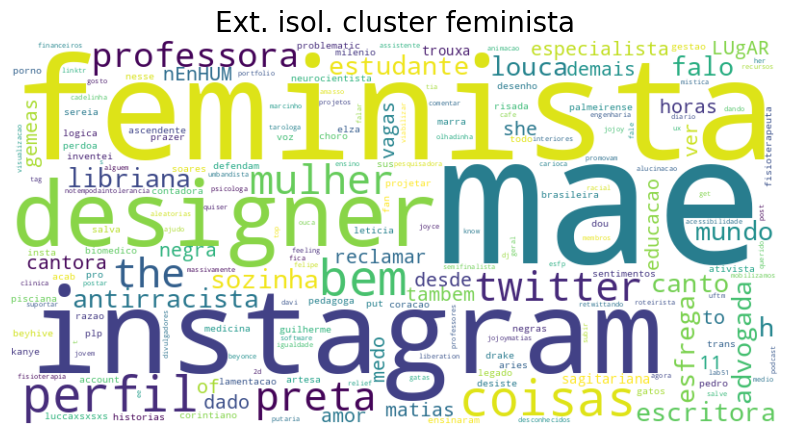

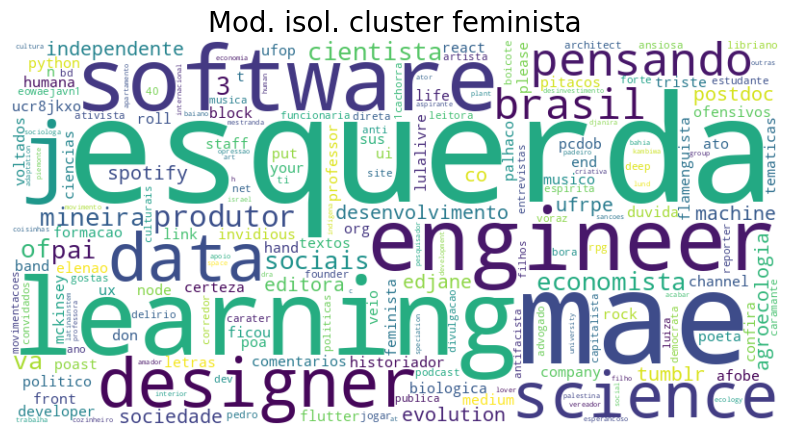

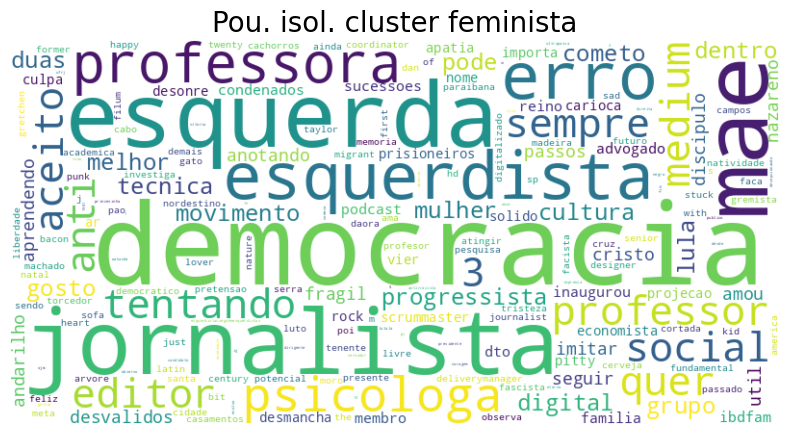

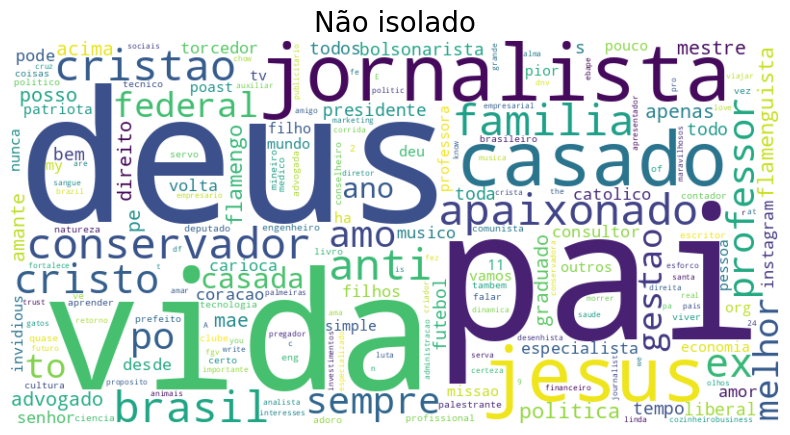

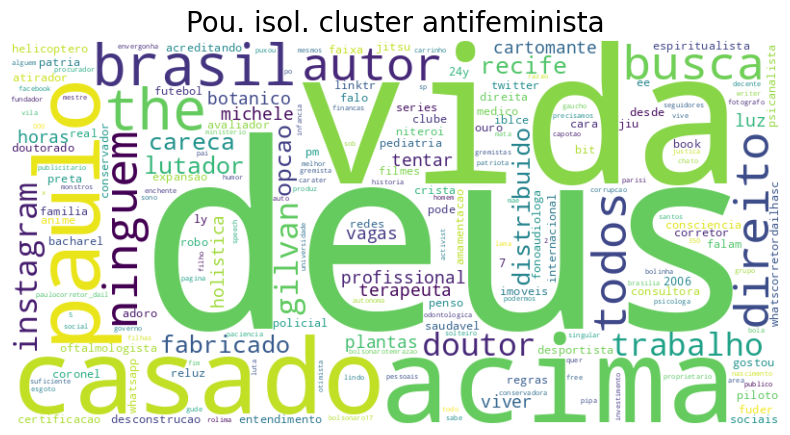

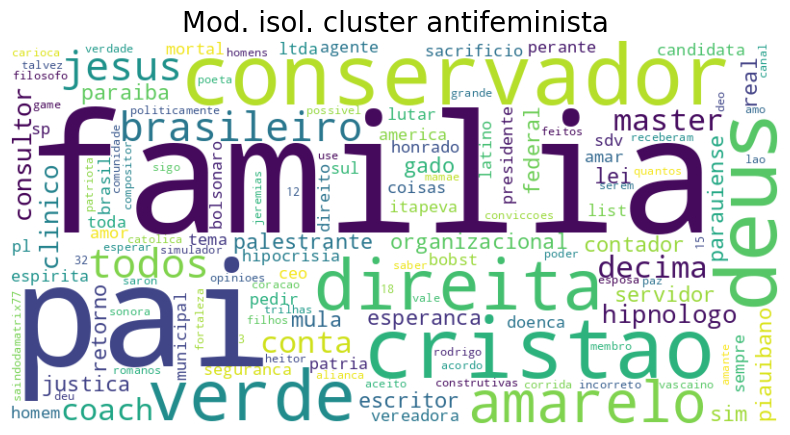

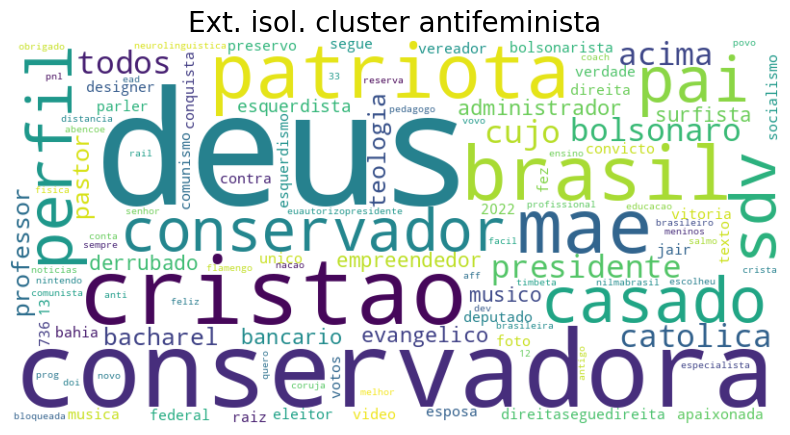

In [12]:
# Word Cloud - bio

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Contar a frequência das palavras para cada classificação ideológica
not_words = ['so', 'and', 'qwertai', 'i', 'in', 'mim']

word_counts = {}
for ideology in influencers_infos['ideology_classification'].unique():
    text = ' '.join(influencers_infos[influencers_infos['ideology_classification'] == ideology]['user_bio_clean'])
    word_counts[ideology] = Counter([w for w in text.split() if w not in not_words])

# Função para gerar word cloud
def generate_wordcloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Gerar Word Cloud para cada ideologia
for ideology, words in word_counts.items():
    generate_wordcloud(words, f"{str.capitalize(ideology)}")


In [13]:
# qual contexto de vida? - nenhum pro vida!
pd.set_option('display.max_colwidth', None)

influencers_infos[influencers_infos.user_bio_clean.str.contains('vida')][['ideology_classification', 'user_bio']]

ideology_classification  \
8266      ext. isol. cluster feminista   
40        mod. isol. cluster feminista   
7026      mod. isol. cluster feminista   
9350      mod. isol. cluster feminista   
6771      pou. isol. cluster feminista   
7632      pou. isol. cluster feminista   
880                        não isolado   
6979                       não isolado   
4                          não isolado   
444                        não isolado   
393                        não isolado   
735                        não isolado   
749                        não isolado   
4106                       não isolado   
7659                       não isolado   
966                        não isolado   
992                        não isolado   
204                        não isolado   
8881  pou. isol. cluster antifeminista   
7194  pou. isol. cluster antifeminista   
2354  pou. isol. cluster antifeminista   
2701  pou. isol. cluster antifeminista   

                                                                                                                                                              user_bio  
8266                                                                                        Feminista, Preta, sagitariana, lésbica otimista e feliz com a própria vida  
40                                                                                                  Na dúvida vá para esquerda. Se tiver certeza, vá para esquerda.🚩🚩🚩  
7026       Podcast de entrevistas com convidados/as para divulgação da música independente e movimentações políticas, sociais e culturais de caráter anti-capitalista.  
9350                                                                                                                                             cachacinha e vida boa  
6771                                                                                        Minha cidade Natal e Natividade da Serra SP. hoje moro em S.J. dos Campos.  
7632                                Um ser humano que já viveu muitas vidas e não tem muita paciência pra conversar mole, o papo é curto e direto, ah! odeio crente...  
880     Nem sou melhor quando me elogiam e nem sou pior quando me criticam. #meufilhominhavida #casada #veterinária #patriota #boldonaro22 #DeusPátriaFamília #animais  
6979                                                                                                                                         Tudo na vida é passageiro  
4                                                                                                               sirvo a Jesus Cristo que deu sua vida por amor a mim .  
444                                                   Amo a VIDA e seu criador, adoro as FLORES gosto de Viajar ,da natureza,um bom livro uma boa música, um bom vinho  
393                                               Flamenguista, católica, casada, mãe. Amo a vida, minha família, meus gatos, música, dar aulas. Amo, simplesmente...♥  
735                                                                                                               Siga a vida sem olhar para traz!\nBem casada @thomaz  
749                                        O tédio me irrita … \n\n“O futebol é coisa mais importante dentre as menos importantes e vida que segue!”\nNelson Rodrigues  
4106                                                                          Libriano, multifacetado e um apaixonado pela vida! Músico, produtor e atleta aposentado.  
7659    Edificando um legado de fé. É como XADREZ. Você pode aprender os princípios em um dia, e passar a VIDA inteira se especializando.\ninsta/tiktok @jesusinbrazil  
966                                                                   Cruzeiro és minha vida! 💙\nOrgulho, minha alegria.\nEngenheiro de produção\n24 anos\n@pedrinhoem  
992                                                                         Amante da vida e de viajar. \nLutando por um Brasil sem corrupção.\nFazendo a minha parte.  
204   

In [14]:
not_words = ['so', 'and', 'qwertai', 'i', 'in', 'mim']

word_counts = {}
for ideology in influencers_infos['ideology_classification'].unique():
    text = ' '.join(influencers_infos[influencers_infos['ideology_classification'] == ideology]['user_bio_clean'])
    word_counts[ideology] = Counter([w for w in text.split() if w not in not_words])

In [15]:
# Top 5 palavras de cada faixa

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

common_words = {ideology: counts.most_common(5) for ideology, counts in word_counts.items()}

# Transformar o dicionário em um DataFrame
rows = []
for ideology, words in common_words.items():
    for word, freq in words:
        rows.append({'ideology': ideology, 'word': word, 'frequency': freq})

df = pd.DataFrame(rows)

# Criar subplots para cada ideologia
ideologies = df['ideology'].unique()
fig = make_subplots(rows=2, cols=4, subplot_titles=ideologies, vertical_spacing=0.3)

# Adicionar um lollipop chart para cada ideologia, ordenando as palavras por frequência crescente
for i, ideology in enumerate(ideologies):
    subset = df[df['ideology'] == ideology].sort_values(by='frequency', ascending=True)
    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(
        go.Scatter(x=subset['word'], y=subset['frequency'],
                   mode='markers+lines',
                   line=dict(color='gray', width=1),
                   marker=dict(color='blue', size=8),
                   name=ideology),
        row=row, col=col
    )

# Atualizar layout do gráfico e definir limites dos eixos Y
fig.update_layout(
    height=800, width=1200,
    title_text="Top 5 Palavras por Faixa Ideológica",
    showlegend=False
)

# Definir os limites dos eixos Y para todos os subplots
fig.update_yaxes(range=[0, 15], title_text="Frequência")
fig.update_xaxes(title_text="Palavras")

# Mostrar o gráfico
fig.show()


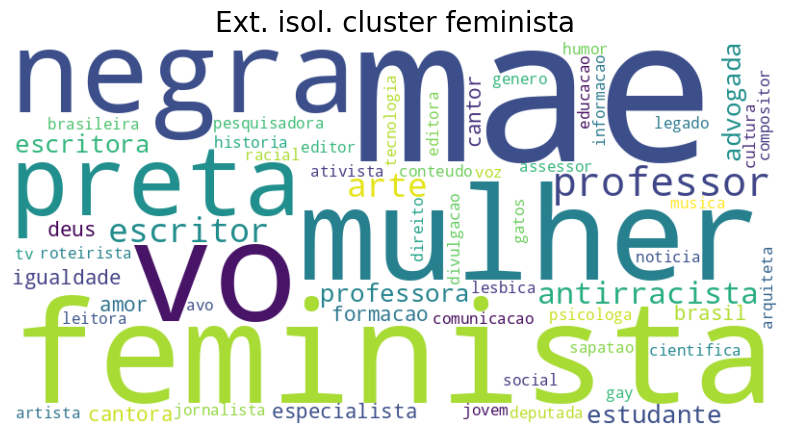

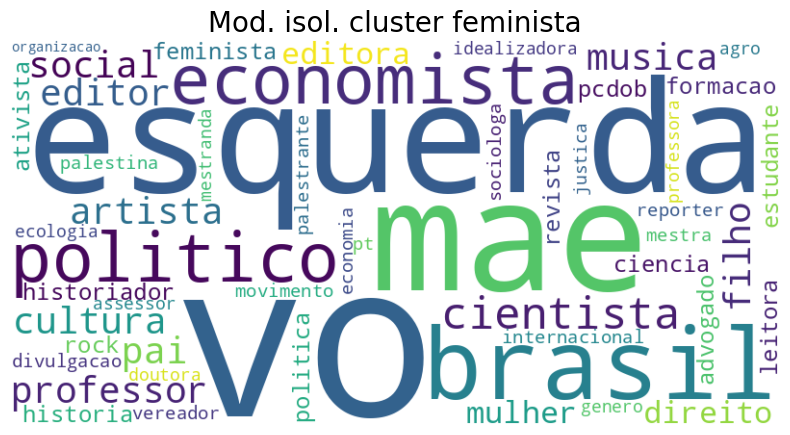

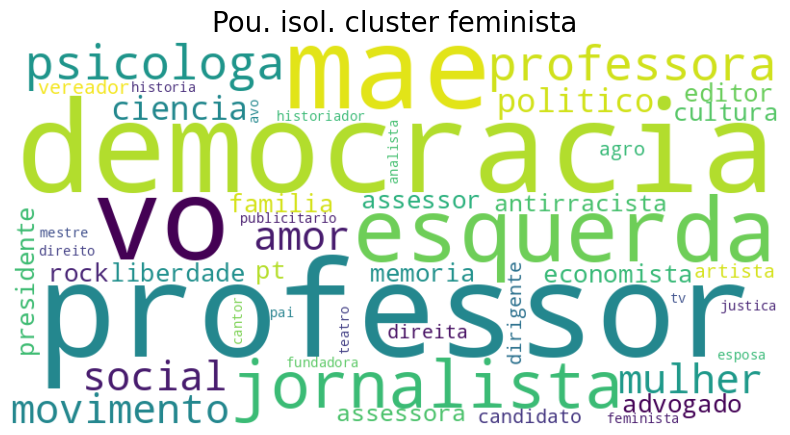

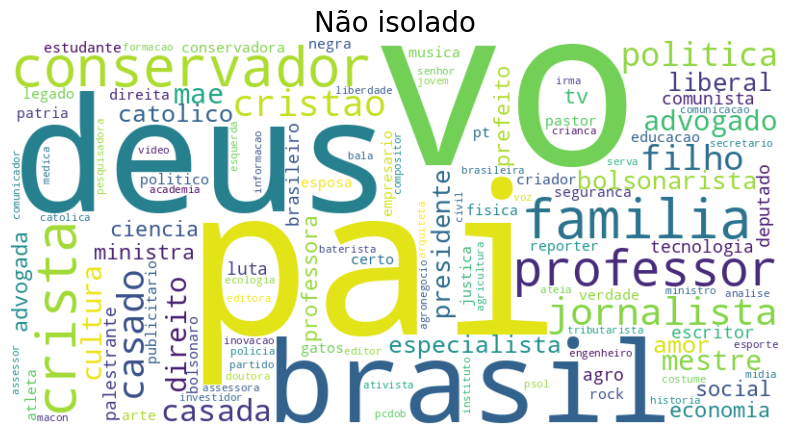

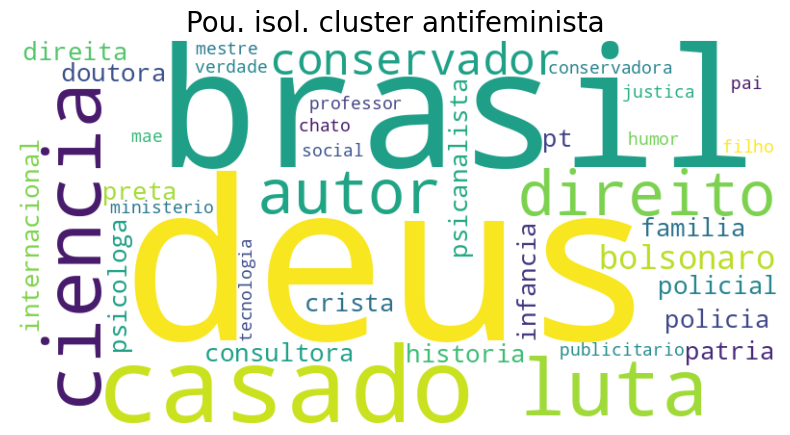

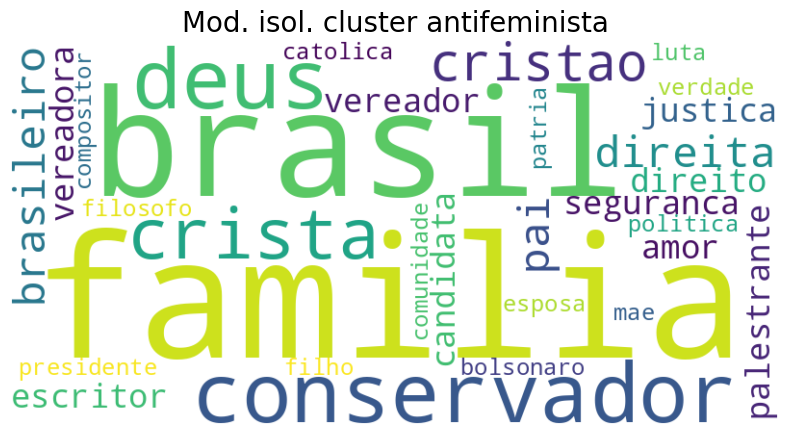

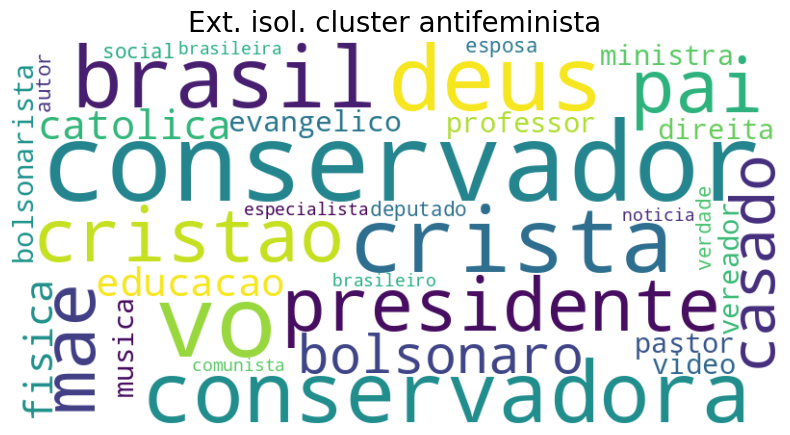

In [16]:
# Word Cloud - keywords

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Contar a frequência das palavras para cada classificação ideológica
word_counts = {}
for ideology in influencers_infos['ideology_classification'].unique():
    text = ' '.join(influencers_infos[influencers_infos['ideology_classification'] == ideology]['key_words_clean'])
    word_counts[ideology] = Counter(text.split())

# Função para gerar word cloud
def generate_wordcloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Gerar Word Cloud para cada ideologia
for ideology, words in word_counts.items():
    generate_wordcloud(words, f"{str.capitalize(ideology)}")


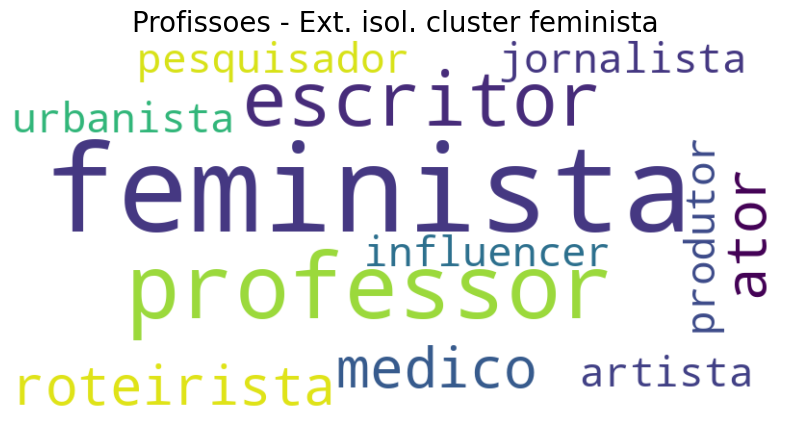

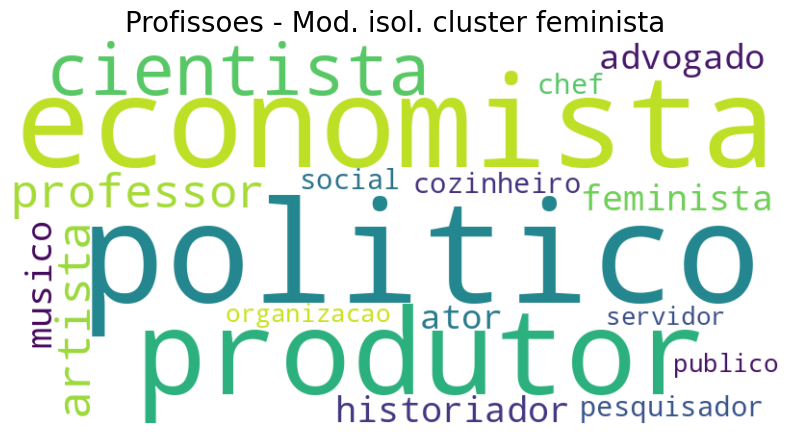

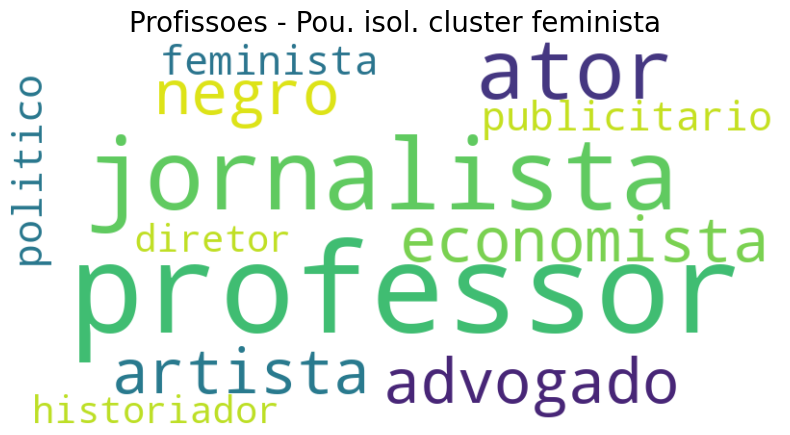

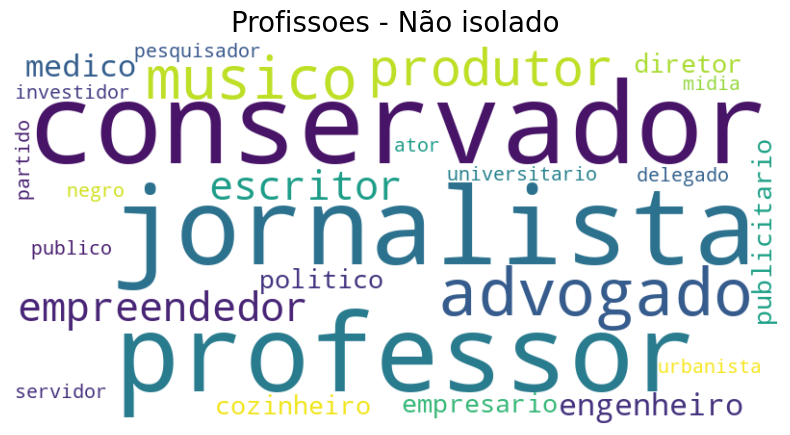

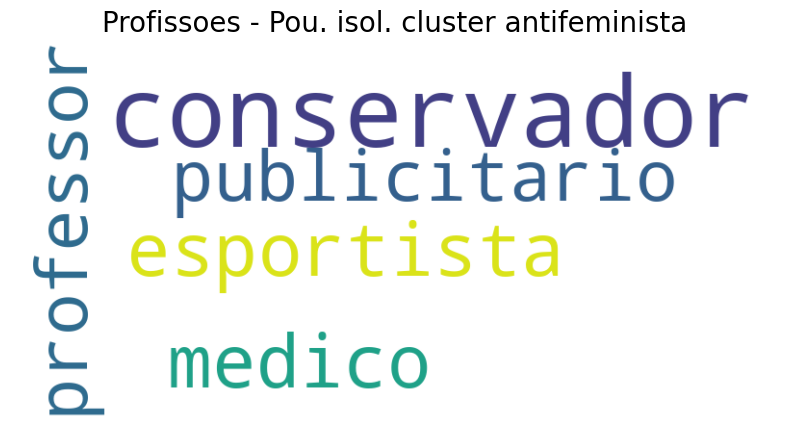

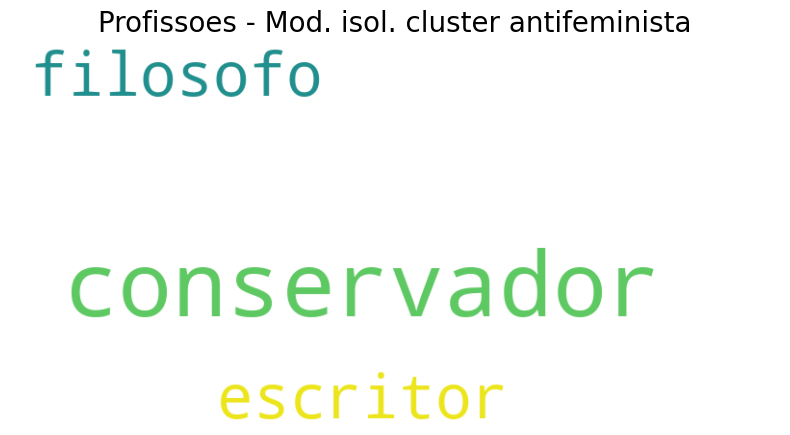

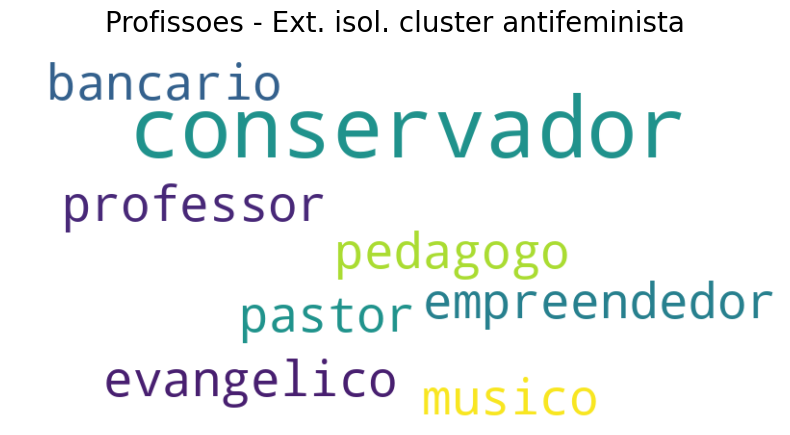

In [17]:
# Word Cloud - profissoes

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Contar a frequência das palavras para cada classificação ideológica
word_counts = {}
for ideology in influencers_infos['ideology_classification'].unique():
    text = ' '.join(influencers_infos[influencers_infos['ideology_classification'] == ideology]['profissoes_clean'])
    word_counts[ideology] = Counter(text.split())

# Função para gerar word cloud
def generate_wordcloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Gerar Word Cloud para cada ideologia
for ideology, words in word_counts.items():
    generate_wordcloud(words, f"Profissoes - {str.capitalize(ideology)}")


In [18]:
# Top 5 palavras de cada faixa

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

common_words = {ideology: counts.most_common(5) for ideology, counts in word_counts.items()}

# Transformar o dicionário em um DataFrame
rows = []
for ideology, words in common_words.items():
    for word, freq in words:
        rows.append({'ideology': ideology, 'word': word, 'frequency': freq})

df = pd.DataFrame(rows)

# Criar subplots para cada ideologia
ideologies = df['ideology'].unique()
fig = make_subplots(rows=2, cols=4, subplot_titles=ideologies, vertical_spacing=0.3)

# Adicionar um lollipop chart para cada ideologia, ordenando as palavras por frequência crescente
for i, ideology in enumerate(ideologies):
    subset = df[df['ideology'] == ideology].sort_values(by='frequency', ascending=True)
    row = i // 4 + 1
    col = i % 4 + 1
    fig.add_trace(
        go.Scatter(x=subset['word'], y=subset['frequency'],
                   mode='markers+lines',
                   line=dict(color='gray', width=1),
                   marker=dict(color='blue', size=8),
                   name=ideology),
        row=row, col=col
    )

# Atualizar layout do gráfico e definir limites dos eixos Y
fig.update_layout(
    height=800, width=1200,
    title_text="Top 5 Palavras por Faixa Ideológica",
    showlegend=False
)

# Definir os limites dos eixos Y para todos os subplots
fig.update_yaxes(range=[0, 15], title_text="Frequência")
fig.update_xaxes(title_text="Palavras")

# Mostrar o gráfico
fig.show()


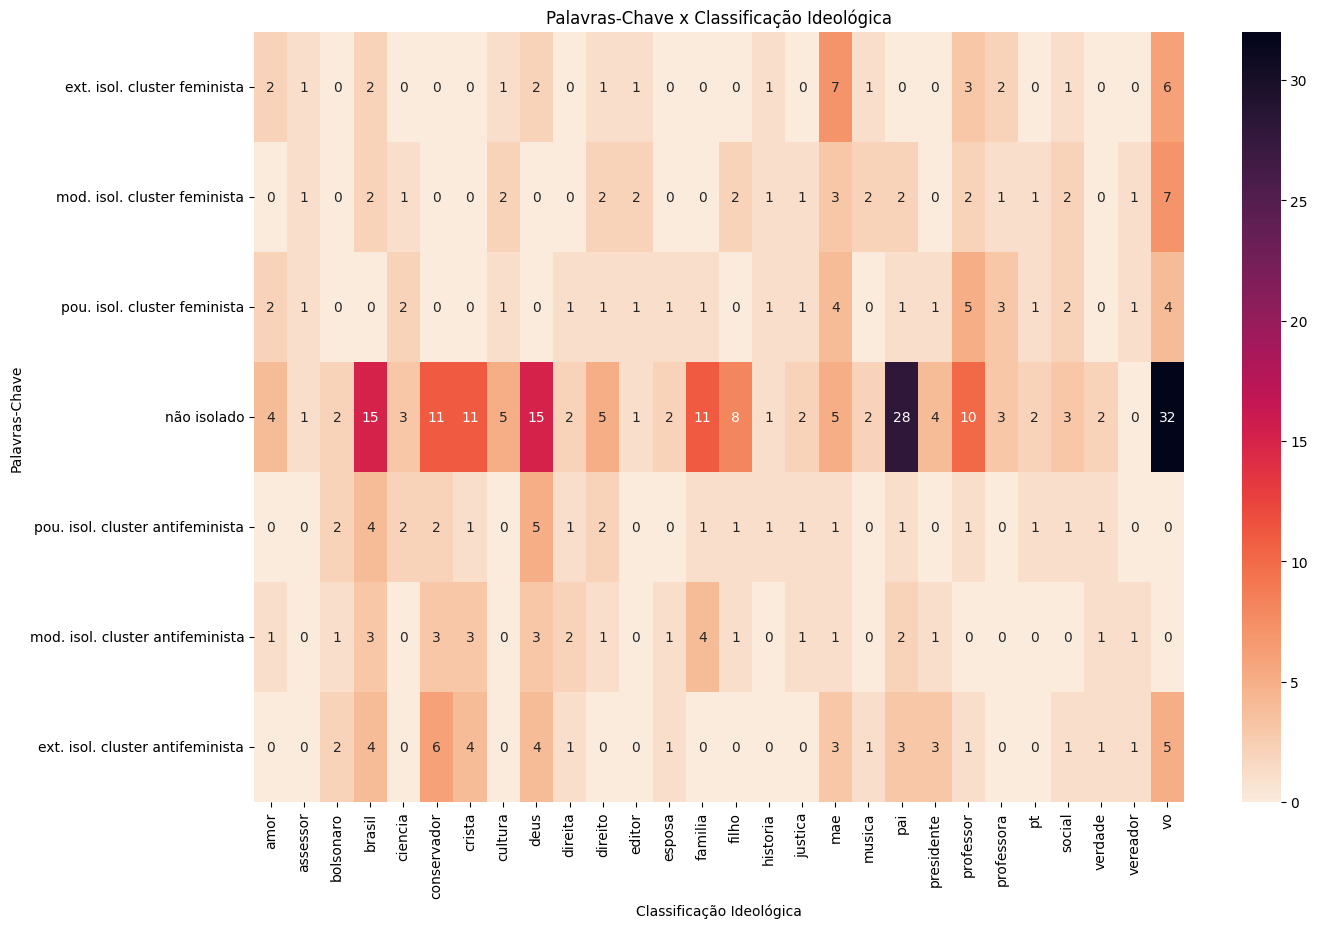

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Passo 1: Vetorizar as palavras-chave
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(influencers_infos['key_words_clean'].fillna(''))

# Passo 2: Criar um DataFrame das palavras-chave com as ideologias como índice
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=influencers_infos['ideology_classification'])

# Passo 3: Agrupar as frequências das palavras-chave por ideologia
keywords_by_ideology = keywords_df.groupby('ideology_classification').sum()

# Passo 4: Filtrar palavras-chave que aparecem em pelo menos um determinado número de registros
min_occurrence = 4
keywords_filtered = keywords_by_ideology.loc[:, (keywords_by_ideology > 0).sum(axis=0) >= min_occurrence]

# Passo 5: Reordenar o DataFrame pelo índice de ideologias na sequência específica
ideologies_ordered = ['ext. isol. cluster feminista',
                       'mod. isol. cluster feminista',
                       'pou. isol. cluster feminista', 
                       'não isolado',
                       'pou. isol. cluster antifeminista',
                       'mod. isol. cluster antifeminista',
                       'ext. isol. cluster antifeminista']

# Verificar se todas as ideologias da lista estão presentes no DataFrame
if all(ideology in keywords_filtered.index for ideology in ideologies_ordered):
    keywords_filtered = keywords_filtered.reindex(ideologies_ordered)
    
    # Verificar se a matriz não está vazia antes de criar o heatmap
    if not keywords_filtered.empty:
        # Passo 6: Criar um heatmap para visualizar a distribuição das palavras-chave por ideologia
        plt.figure(figsize=(15, 10))
        sns.heatmap(keywords_filtered, cmap="rocket_r", annot=True, fmt="d")
        plt.title("Palavras-Chave x Classificação Ideológica")
        plt.xlabel("Classificação Ideológica")
        plt.ylabel("Palavras-Chave")
        plt.show()
    else:
        print("Nenhuma palavra-chave suficiente para criar o heatmap após a filtragem.")
else:
    print("Algumas ideologias na lista de ordenação não estão presentes no DataFrame.")


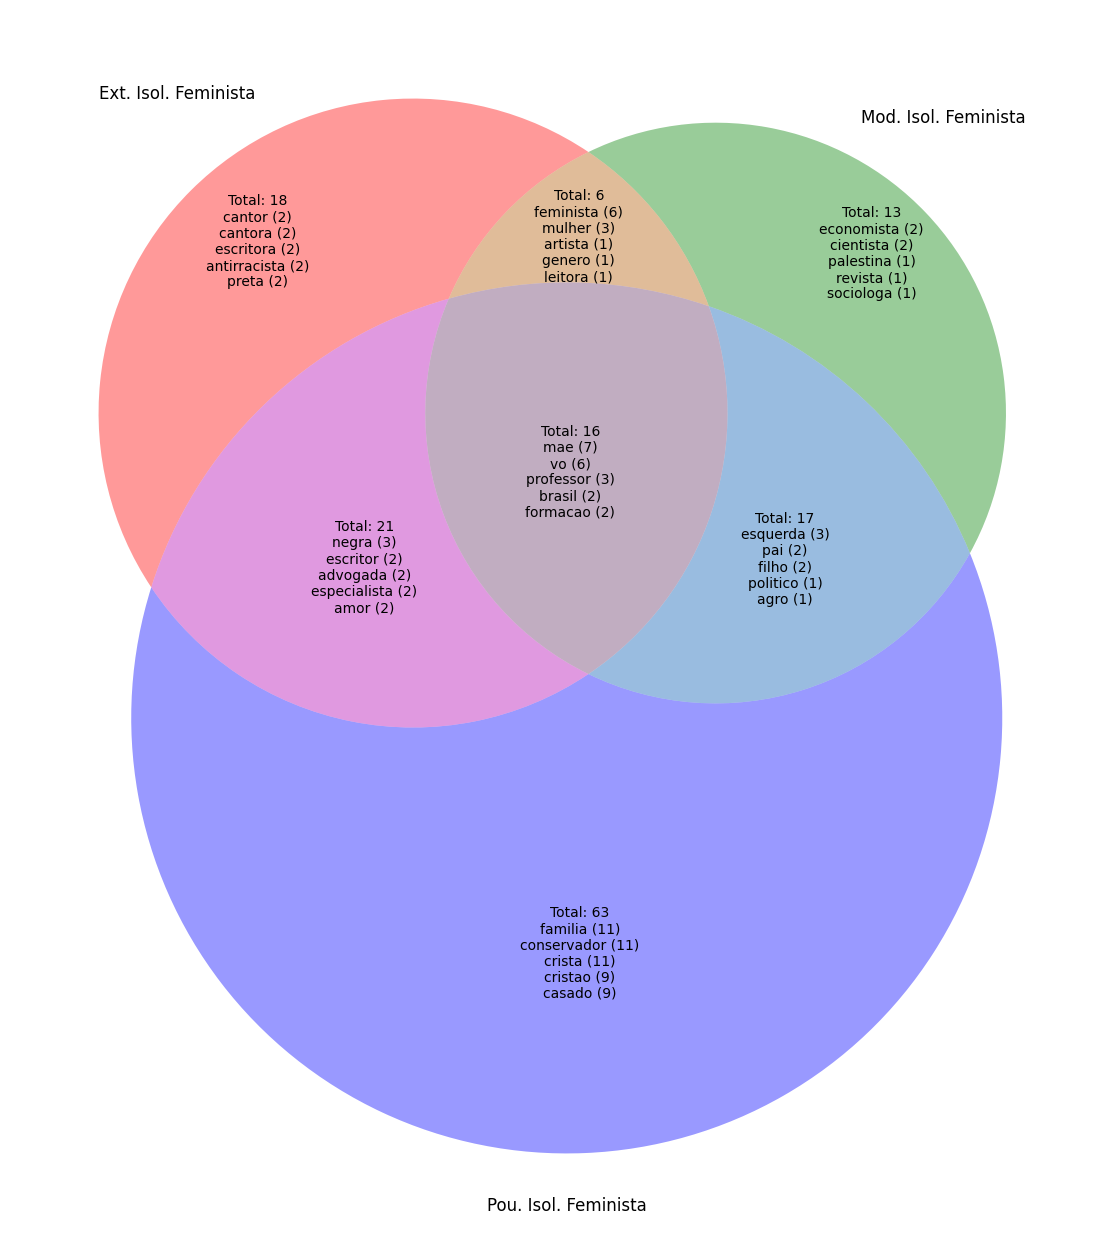

In [20]:
# O que ha em comum entre as feministas e o centro?

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Usar CountVectorizer para contar a presença de palavras nas colunas de palavras-chave
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(influencers_infos['key_words_clean'])

# Criar um DataFrame com as palavras e suas frequências por ideologia
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=influencers_infos['ideology_classification_old'])

# Agrupar por classificação ideológica e somar as ocorrências
keywords_by_ideology = keywords_df.groupby('ideology_classification_old').sum()

# Exemplo para 3 faixas ideológicas: Feminista Extrema, Feminista Moderada, e Centro
set1 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['feminista extrema'] > 0])
set2 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['feminista moderada'] > 0])
set3 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['centro'] > 0])

# Identificar palavras comuns e específicas
common_12 = set1 & set2
common_13 = set1 & set3
common_23 = set2 & set3
common_123 = set1 & set2 & set3

# Função para obter as top 5 palavras mais frequentes com suas frequências
def get_top_5_words_with_freq(words, group):
    words_list = list(words)  # Converter o conjunto para uma lista
    freq = keywords_by_ideology.loc[group, words_list].sort_values(ascending=False)
    return [f"{word} ({freq[word]})" for word in freq.index[:5]]

# Função para combinar as top 5 palavras com a contagem total
def get_label_text(words, group):
    top_5_words = get_top_5_words_with_freq(words, group)
    total_count = len(words)
    return f"Total: {total_count}\n" + "\n".join(top_5_words)

# Criar o gráfico de Venn
plt.figure(figsize=(16, 16))  # Aumentar o tamanho da figura
venn = venn3([set1, set2, set3], ('Ext. Isol. Feminista', 'Mod. Isol. Feminista', 'Pou. Isol. Feminista'))

# Customizar os rótulos para mostrar as top 5 palavras com suas frequências e o total de palavras
venn.get_label_by_id('100').set_text(get_label_text(set1 - common_12 - common_13, 'feminista extrema'))
venn.get_label_by_id('010').set_text(get_label_text(set2 - common_12 - common_23, 'feminista moderada'))
venn.get_label_by_id('001').set_text(get_label_text(set3 - common_13 - common_23, 'centro'))
venn.get_label_by_id('110').set_text(get_label_text(common_12 - common_123, 'feminista extrema'))
venn.get_label_by_id('101').set_text(get_label_text(common_13 - common_123, 'feminista extrema'))
venn.get_label_by_id('011').set_text(get_label_text(common_23 - common_123, 'feminista moderada'))
venn.get_label_by_id('111').set_text(get_label_text(common_123, 'feminista extrema'))

plt.show()


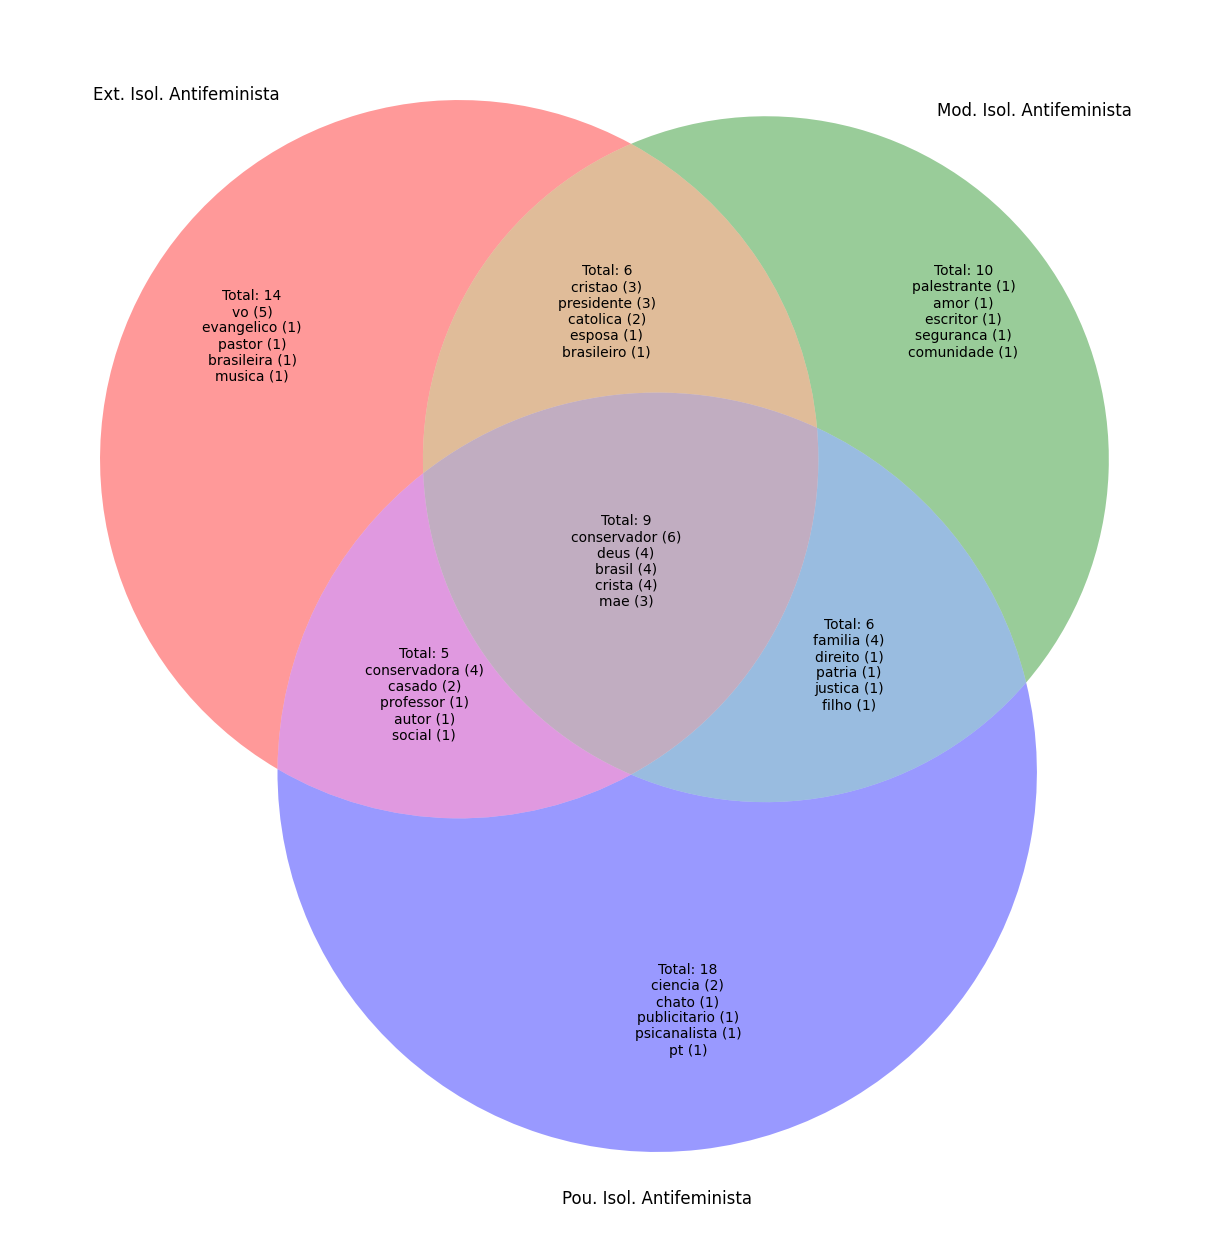

In [21]:
# O que ha em comum entre antifeministas?

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Usar CountVectorizer para contar a presença de palavras nas colunas de palavras-chave
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(influencers_infos['key_words_clean'])

# Criar um DataFrame com as palavras e suas frequências por ideologia
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=influencers_infos['ideology_classification_old'])

# Agrupar por classificação ideológica e somar as ocorrências
keywords_by_ideology = keywords_df.groupby('ideology_classification_old').sum()

# Exemplo para 3 faixas ideológicas: Feminista Extrema, Feminista Moderada, e Centro
set1 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['antifeminista extrema'] > 0])
set2 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['antifeminista moderada'] > 0])
set3 = set(keywords_by_ideology.columns[keywords_by_ideology.loc['antifeminista centro'] > 0])

# Identificar palavras comuns e específicas
common_12 = set1 & set2
common_13 = set1 & set3
common_23 = set2 & set3
common_123 = set1 & set2 & set3

# Função para obter as top 5 palavras mais frequentes com suas frequências
def get_top_5_words_with_freq(words, group):
    words_list = list(words)  # Converter o conjunto para uma lista
    freq = keywords_by_ideology.loc[group, words_list].sort_values(ascending=False)
    return [f"{word} ({freq[word]})" for word in freq.index[:5]]

# Função para combinar as top 5 palavras com a contagem total
def get_label_text(words, group):
    top_5_words = get_top_5_words_with_freq(words, group)
    total_count = len(words)
    return f"Total: {total_count}\n" + "\n".join(top_5_words)

# Criar o gráfico de Venn
plt.figure(figsize=(16, 16))  # Aumentar o tamanho da figura
venn = venn3([set1, set2, set3], ('Ext. Isol. Antifeminista', 'Mod. Isol. Antifeminista', 'Pou. Isol. Antifeminista'))

# Customizar os rótulos para mostrar as top 5 palavras com suas frequências e o total de palavras
venn.get_label_by_id('100').set_text(get_label_text(set1 - common_12 - common_13, 'antifeminista extrema'))
venn.get_label_by_id('010').set_text(get_label_text(set2 - common_12 - common_23, 'antifeminista moderada'))
venn.get_label_by_id('001').set_text(get_label_text(set3 - common_13 - common_23, 'antifeminista centro'))
venn.get_label_by_id('110').set_text(get_label_text(common_12 - common_123, 'antifeminista extrema'))
venn.get_label_by_id('101').set_text(get_label_text(common_13 - common_123, 'antifeminista extrema'))
venn.get_label_by_id('011').set_text(get_label_text(common_23 - common_123, 'antifeminista moderada'))
venn.get_label_by_id('111').set_text(get_label_text(common_123, 'antifeminista extrema'))

plt.show()


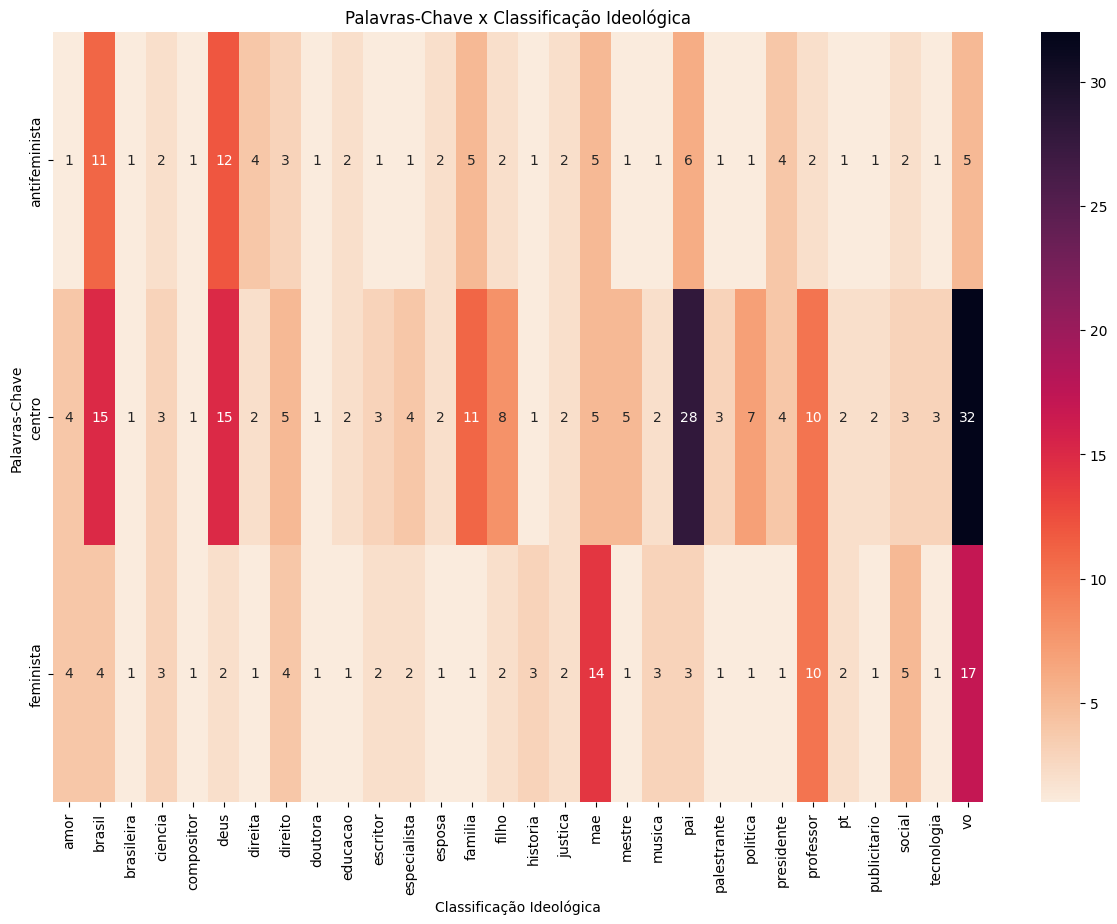

In [22]:
# Palavras-Chave x Classificação Ideológica

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Passo 1: Vetorizar as palavras-chave
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(influencers_infos['key_words_clean'].fillna(''))

# Passo 2: Criar um DataFrame das palavras-chave com as ideologias como índice
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=influencers_infos['ideology_classification_gen'])

# Passo 3: Agrupar as frequências das palavras-chave por ideologia
keywords_by_ideology = keywords_df.groupby('ideology_classification_gen').sum()

# Passo 4: Filtrar palavras-chave que aparecem em pelo menos um determinado número de registros
min_occurrence = 3
keywords_filtered = keywords_by_ideology.loc[:, (keywords_by_ideology > 0).sum(axis=0) >= min_occurrence]

# Verificar se a matriz não está vazia antes de criar o heatmap
if not keywords_filtered.empty:
    # Passo 5: Criar um heatmap para visualizar a distribuição das palavras-chave por ideologia
    plt.figure(figsize=(15, 10))
    sns.heatmap(keywords_filtered, cmap="rocket_r", annot=True, fmt="d")
    plt.title("Palavras-Chave x Classificação Ideológica")
    plt.xlabel("Classificação Ideológica")
    plt.ylabel("Palavras-Chave")
    plt.show()
else:
    print("Nenhuma palavra-chave suficiente para criar o heatmap após a filtragem.")


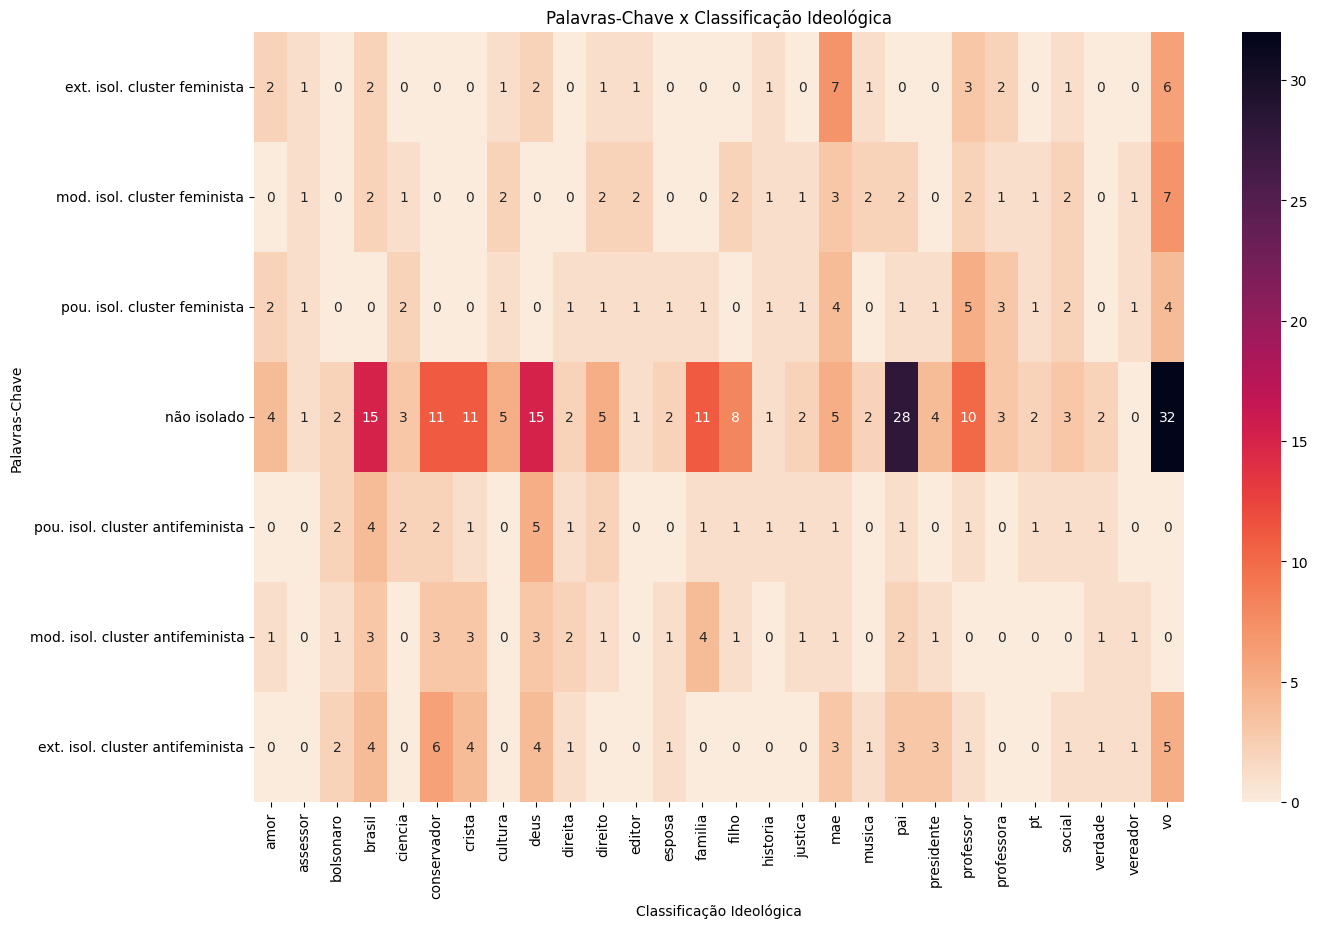

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Passo 1: Vetorizar as palavras-chave
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(influencers_infos['key_words_clean'].fillna(''))

# Passo 2: Criar um DataFrame das palavras-chave com as ideologias como índice
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=influencers_infos['ideology_classification'])

# Passo 3: Agrupar as frequências das palavras-chave por ideologia
keywords_by_ideology = keywords_df.groupby('ideology_classification').sum()

# Passo 4: Filtrar palavras-chave que aparecem em pelo menos um determinado número de registros
min_occurrence = 4
keywords_filtered = keywords_by_ideology.loc[:, (keywords_by_ideology > 0).sum(axis=0) >= min_occurrence]

# Passo 5: Reordenar o DataFrame pelo índice de ideologias na sequência específica
ideologies_ordered = ['ext. isol. cluster feminista',
                       'mod. isol. cluster feminista',
                       'pou. isol. cluster feminista', 
                       'não isolado',
                       'pou. isol. cluster antifeminista',
                       'mod. isol. cluster antifeminista',
                       'ext. isol. cluster antifeminista']

# Verificar se todas as ideologias da lista estão presentes no DataFrame
if all(ideology in keywords_filtered.index for ideology in ideologies_ordered):
    keywords_filtered = keywords_filtered.reindex(ideologies_ordered)
    
    # Verificar se a matriz não está vazia antes de criar o heatmap
    if not keywords_filtered.empty:
        # Passo 6: Criar um heatmap para visualizar a distribuição das palavras-chave por ideologia
        plt.figure(figsize=(15, 10))
        sns.heatmap(keywords_filtered, cmap="rocket_r", annot=True, fmt="d")
        plt.title("Palavras-Chave x Classificação Ideológica")
        plt.xlabel("Classificação Ideológica")
        plt.ylabel("Palavras-Chave")
        plt.show()
    else:
        print("Nenhuma palavra-chave suficiente para criar o heatmap após a filtragem.")
else:
    print("Algumas ideologias na lista de ordenação não estão presentes no DataFrame.")


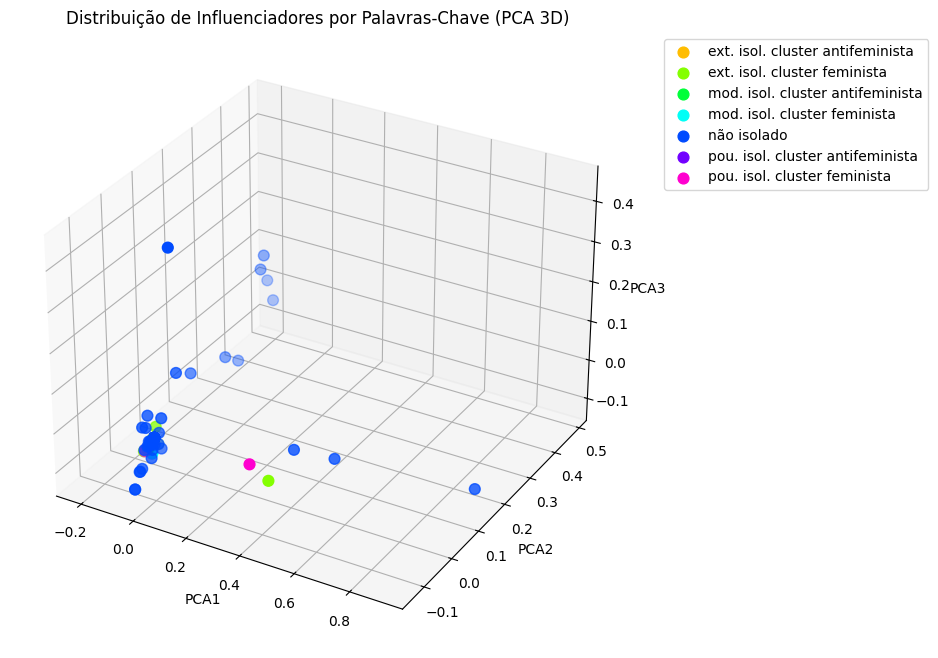

In [24]:
# PCA 3D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# 1. Vetorização do texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(influencers_infos['key_words_clean'].fillna(''))

# Aplicar K-Means para agrupar os influenciadores
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Adicionar a coluna de clusters ao DataFrame original
influencers_infos['cluster'] = clusters

# 2. Aplicar PCA para reduzir a dimensionalidade para 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Criar um DataFrame para a visualização
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['ideology_classification'] = influencers_infos['ideology_classification']

# Visualização 3D com cores para ideologias
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Mapeamento de cores para as classificações ideológicas
colors = sns.color_palette("hsv", len(influencers_infos['ideology_classification'].unique()))

# Plotar cada ponto no gráfico 3D
for i, (name, group) in enumerate(pca_df.groupby('ideology_classification')):
    ax.scatter(
        group['PCA1'], 
        group['PCA2'], 
        group['PCA3'], 
        label=name, 
        color=colors[i], 
        s=60
    )

ax.set_title('Distribuição de Influenciadores por Palavras-Chave (PCA 3D)')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [25]:
# PCA 3D
import plotly.express as px
import pandas as pd

# PCA com 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Atualizar DataFrame com os 3 componentes
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['cluster'] = clusters
pca_df['ideology_classification'] = influencers_infos['ideology_classification']

# Visualização 3D com Plotly
fig = px.scatter_3d(
    pca_df, 
    x='PCA1', 
    y='PCA2', 
    z='PCA3', 
    color='cluster', 
    # color='ideology_classification', 
    # symbol='cluster', 
    title='Clustering de Influenciadores por Palavras-Chave (PCA 3D)',
    labels={'ideology_classification': 'Ideology', 'cluster': 'Cluster'}
)

fig.update_traces(marker=dict(size=5))
fig.show()


In [26]:
# quem sao os "diferentoes" do cluster 1?

# pca_df['nome'] = influencers_infos['nome']
pca_df['user_bio'] = influencers_infos['user_bio']
# pca_df['key_words_clean'] = influencers_infos['key_words_clean']

pca_df[pca_df['cluster'] == 1]

PCA1      PCA2      PCA3  cluster       ideology_classification  \
0   -0.049750 -0.059634 -0.034377        1  pou. isol. cluster feminista   
1   -0.049750 -0.059634 -0.034377        1                   não isolado   
2   -0.049750 -0.059634 -0.034377        1                           NaN   
3   -0.049750 -0.059634 -0.034377        1                           NaN   
4   -0.049750 -0.059634 -0.034377        1                   não isolado   
..        ...       ...       ...      ...                           ...   
480 -0.049750 -0.059634 -0.034377        1  mod. isol. cluster feminista   
481 -0.118827  0.312576  0.365096        1                           NaN   
482 -0.049750 -0.059634 -0.034377        1                           NaN   
483  0.409193  0.031218 -0.010801        1                           NaN   
484 -0.049750 -0.059634 -0.034377        1                           NaN   

                                                                                                user_bio  
0    Advogado, Professor de Dto de Família e Sucessões. membro do Ibdfam. Podcast “Prisioneiros do Rock”  
1                                                          Locutor De Rodeio \nApresentador \nPecuarista  
2                                                                                                    NaN  
3                                                                                                    NaN  
4                                                 sirvo a Jesus Cristo que deu sua vida por amor a mim .  
..                                                                                                   ...  
480                                                                                      falando sozinha  
481                                                                                                  NaN  
482                                                                                                  NaN  
483                                                                                                  NaN  
484                                                                                                  NaN  

[457 rows x 6 columns]

In [27]:
influencers_infos.columns

Index(['user_id', 'user_bio', 'location', 'ideology_rate',
       'ideology_classification', 'ideology_classification_gen',
       'account_creation_date', 'last_tweet_date', 'tweets_count',
       'followers_count', 'following_count', 'soma_influencers',
       'soma_influencers_fem', 'soma_influencers_anti', 'user_bio_clean',
       'user_profissoes', 'user_keywords', 'key_words_clean',
       'profissoes_clean', 'ideology_classification_old', 'cluster'],
      dtype='object')